In [1]:
from collections import defaultdict
from typing import Tuple
import numpy as np
import pandas as pd

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

In [11]:
with open('runs/fullpareto.txt') as fh:
    lines = fh.readlines()

In [12]:
# saved because it's useful later, moreso than now.
first_definition = [i for i, line in enumerate(lines) if ':=' in line][0]

print("The predefined defaults are:")
for line in lines[first_definition:]:
    if ':=' in line:
        print(f" * {line[len('INFO:root:'):-1]}")

The predefined defaults are:
 * sklearn_scale := make_tuple(1., truediv(1., mul(p, xvar)))
 * symbolic_best := make_tuple(16., truediv(mkd, xvar))
 * symbolic_v2 := make_tuple(m, add(mkd, mkd)))
 * const := make_tuple(812.267350, 0.001361)


In [13]:
benchmarks = ["const", "sklearn_scale", "symbolic_best", "symbolic_v2"]

In [14]:
task_starts = [i for i, line in enumerate(lines) if "INFO:root:START_TASK:" in line]
in_sample_starts = [i for i, line in enumerate(lines) if "INFO:root:Evaluating in sample:" in line]
out_sample_starts = [i for i, line in enumerate(lines) if "INFO:root:Evaluating out-of-sample:" in line]

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

In [15]:
def parse_evaluation_line(line) -> Tuple[str, int, float]:
    """ Parse an evaluation line, returning the expression or name, its 'length' and the score.
    
    e.g. INFO:root:[make_tuple(p, mkd)|0.8893]\n -> 'make_tuple(p, mkd)', 1, 0.8893 
    Length is 0 for benchmark problems.
    """
    start, pipe, end = line.find('['), line.find('|'), line.find(']')
    expression = line[start + 1 : pipe]
    expression_length = expression.count('(')
    return expression, expression_length, float(line[pipe + 1 : end])

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

In [37]:
tasks = [int(line[:-1].split(": ")[-1]) for line in lines if "INFO:root:START_TASK:" in line]
idx = pd.MultiIndex.from_product([tasks, ["in-sample", "out-sample"]], names=['task', 'sample-type'])
df = pd.DataFrame(index=idx, columns=["score-1","score-2", "score-3", "score-best", *benchmarks], dtype=float)

In [45]:
expressions_by_length = defaultdict(list)
generations_by_task = {}

for task_start, in_start, out_start, next_task in zip(task_starts, in_sample_starts, out_sample_starts, task_starts[1:] + [first_definition]):
    # start line looks like: INFO:root:START_TASK: 29\n
    task = int(lines[task_start][:-1].split(": ")[-1])
    
    # Since the in-sample evaluation message follows directly after optimization is done, we use that to record
    # the number of generations. We account for the early stopping message if it did not run to 200 generations.
    ended_early = 0 if in_start - task_start == 201 else - 1
    generations_by_task[task] = in_start - (task_start + 1) - ended_early
    
    # Following the "INFO:root:Evaluating in sample:" message, symbolic default performance are printed
    # They are formatted as "INFO:root:[make_tuple(p, mkd)|0.8893]"
    # First is any number of best solutions from the pareto front. The last four are benchmark solutions.
    # It is possible that two equally good solutions are printed (i.e. same length and performance).    
    expr_in_task = set()
    
#     in_sample_evaluation_lines = lines[in_start + 1 : out_start]
#     in_sample_evaluations = [parse_evaluation_line(eval_) for eval_ in in_sample_evaluation_lines]
#     max_len = max([len_ for _, len_, _ in in_sample_evaluations])
#     expr_in_task = {expr for expr, _, _ in in_sample_evaluations}
    max_length = 0
    
    for in_sample_evaluation in lines[in_start + 1 : out_start]:
        expr, length, score = parse_evaluation_line(in_sample_evaluation)
        # Pareto fronts may contain literal duplicates, so we filter those out manually.
        if expr not in expr_in_task:
            expressions_by_length[length].append(expr)
            expr_in_task.add(expr)
        
        if length !=0:
            if length < 4:
                # Only report one out-of-sample solution for each length (and all benchmarks), so overwrite is OK.
                df.loc[task, "in-sample"][f"score-{length}"] = score
                
            # Update best so far score and maximum length
            df.loc[task, "in-sample"][f"score-best"] = np.nanmax([score, df.loc[task, "in-sample"][f"score-best"]])
            max_length = max(max_length, length)
        else:
            df.loc[task, "in-sample"][expr] = score
            
        if length > max_length:
            max_length = length  # To know for which length "best" should score out of sample
    
    # Because two equal solutions can be in the Pareto front, 
    # we note the average out of sample performance if multiple solutions were found.
    # Naturally, the solutions with the best in-sample score were those with the highest length in the Pareto front.
    
    scores_by_length = defaultdict(list)
    
    for out_sample_evaluation in lines[out_start + 1 : next_task]:
        expr, length, score = parse_evaluation_line(out_sample_evaluation)   
        if length !=0:
            scores_by_length[length].append(score)
        else:
            df.loc[task, "out-sample"][expr] = score
            
    for length, scores in scores_by_length.items():
        if length < 4:
            df.loc[task, "out-sample"][f"score-{length}"] = np.mean(scores)
        if length == max_length:
            df.loc[task, "out-sample"][f"score-best"] = np.mean(scores)
        if np.mean(scores) == float("nan"):
            print('hi')
    

In [46]:
for length, expressions in sorted(expressions_by_length.items()):
    m = max(set(expressions), key=expressions.count)
    print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")

 Found 424 expressions of length 0. Most frequent: sklearn_scale (106 times)
 Found 106 expressions of length 1. Most frequent: make_tuple(p, mkd) (106 times)
 Found 114 expressions of length 2. Most frequent: make_tuple(m, truediv(mkd, xvar)) (57 times)
 Found  68 expressions of length 3. Most frequent: make_tuple(truediv(m, mcp), truediv(mkd, xvar)) (6 times)
 Found  31 expressions of length 4. Most frequent: make_tuple(add(min(p, m), xvar), truediv(mkd, xvar)) (1 times)
 Found  17 expressions of length 5. Most frequent: make_tuple(mul(truediv(m, xvar), truediv(truediv(m, xvar), xvar)), mkd) (1 times)
 Found  12 expressions of length 6. Most frequent: make_tuple(sub(mul(truediv(m, xvar), truediv(truediv(m, xvar), xvar)), xvar), mkd) (1 times)
 Found   6 expressions of length 7. Most frequent: make_tuple(m, truediv(mkd, mul(xvar, min(max(mul(p, mkd), pow(0.125, xvar)), 2.0)))) (1 times)
 Found   1 expressions of length 8. Most frequent: make_tuple(truediv(truediv(if_gt(mkd, add(0.0592

"Found `N` expressions of length `L`" here means across all the tasks' pareto fronts `N` solutions have length `L`.
Pareto fronts may contain duplicate entries.

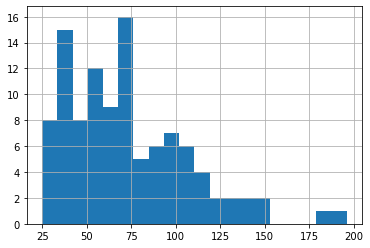

In [47]:
pd.Series(generations_by_task, name="generations").hist(bins=20)

Above plot shows the histogram of the number of generations across tasks (binsize=10).
Note that if something ran for less than 200 generations, it found its optimum 20 generations earlier and early stopping terminated search.

In [48]:
df

score-1  score-2  score-3  score-best   const  \
task   sample-type                                                  
3      in-sample     0.8896   0.9018   0.9040      0.9040  0.8608   
       out-sample    0.9641   0.9132   0.9146      0.9146  0.9420   
6      in-sample     0.8894   0.8998   0.9014      0.9014  0.8609   
       out-sample    0.9893   0.9912   0.9917      0.9917  0.9355   
11     in-sample     0.8902   0.9020   0.9046      0.9047  0.8612   
...                     ...      ...      ...         ...     ...   
189928 out-sample    0.9249   0.9397   0.9423      0.9423  0.8361   
190411 in-sample     0.8902   0.8903      NaN      0.8903  0.8613   
       out-sample    0.9041   0.9041      NaN      0.9041  0.8884   
190412 in-sample     0.8915   0.8929      NaN      0.8929  0.8674   
       out-sample    0.7625   0.7375      NaN      0.7375  0.2500   

                    sklearn_scale  symbolic_best  symbolic_v2  
task   sample-type                                             
3      in-sample           0.8870         0.8949       0.8855  
       out-sample          0.9193         0.9816       0.8774  
6      in-sample           0.8865         0.8948       0.8843  
       out-sample          0.9681         0.9893       0.9958  
11     in-sample           0.8873         0.8951       0.8852  
...                           ...            ...          ...  
189928 out-sample          0.8853         0.9782       0.8864  
190411 in-sample           0.8874         0.8954       0.8854  
       out-sample          0.8788         0.9301       0.8811  
190412 in-sample           0.8914         0.8972       0.8883  
       out-sample          0.4536         0.7339       0.5789  

[212 rows x 8 columns]

In [49]:
out_sample = df.index.map(lambda idx: idx[1] == "out-sample")
df.loc[out_sample]

,,score-1,score-2,score-3,score-best,const,sklearn_scale,symbolic_best,symbolic_v2
task,sample-type,,,,,,,,
3,out-sample,0.9641,0.9132,0.9146,0.9146,0.9420,0.9193,0.9816,0.8774
6,out-sample,0.9893,0.9912,0.9917,0.9917,0.9355,0.9681,0.9893,0.9958
11,out-sample,0.9035,0.8982,0.9025,0.9029,0.8968,0.8807,0.9531,0.9050
12,out-sample,0.9990,0.9988,NaN,0.9988,0.9983,0.9925,0.9985,0.9958
14,out-sample,0.9960,0.9944,NaN,0.9944,0.9926,0.9647,0.9958,0.9867
...,...,...,...,...,...,...,...,...,...
189924,out-sample,0.6658,0.6658,NaN,0.6658,0.5543,0.7663,0.9862,0.5274
189927,out-sample,0.9457,0.9695,0.9478,0.9478,0.9355,0.9692,0.9695,0.8911
189928,out-sample,0.9249,0.9397,0.9423,0.9423,0.8361,0.8853,0.9782,0.8864


We compare the scores and note which solution leads to the best out of sample score per task. A solution wins **alone** if all other solutions have worse performance. It wins **shared** if at least one other solution has the same score, but no solution has a better score. **either** is the sum of alone and shared.

In [94]:
alone = defaultdict(int)
shared = defaultdict(int)
for _, out in df.loc[out_sample].iterrows():
    best = out[out == out.max()].index.values
    if len(best) == 1:
        alone[best[0]] += 1
    else:
        for winner in best:
            shared[winner] += 1

In [95]:
alone = {k: alone[k] for k in sorted(alone)}
shared = {k: shared[k] for k in sorted(shared)}
either = {k: shared[k] + alone[k] for k in sorted(shared)}
pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])

,const,score-1,score-2,score-3,score-best,sklearn_scale,symbolic_best,symbolic_v2
alone,11,22,1,1,1,14,16,16
shared,3,8,16,11,18,2,8,3
either,14,30,17,12,19,16,24,19


But tallying wins does not say much about the robustness of the symbolic defaults. We can also compare the average or median distance from the top performer:

In [108]:
df_out = df.loc[out_sample].copy()

In [109]:
df_out['max'] = df_out.max(axis=1)
for col in df_out:
    df_out['d_'+col] = df_out['max'] - df_out[col]

In [111]:
d_cols = [c for c in df_out.columns if c.startswith('d_')]
df_out[d_cols].mean()

d_score-1          0.043785
d_score-2          0.042344
d_score-3          0.029300
d_score-best       0.042664
d_const            0.072528
d_sklearn_scale    0.046802
d_symbolic_best    0.038395
d_symbolic_v2      0.048700
d_max              0.000000
dtype: float64

In [112]:
df_out[d_cols].median()

d_score-1          0.01520
d_score-2          0.01325
d_score-3          0.00850
d_score-best       0.01155
d_const            0.02750
d_sklearn_scale    0.01770
d_symbolic_best    0.00585
d_symbolic_v2      0.01125
d_max              0.00000
dtype: float64

Looking at in-sample performance:

In [96]:
in_sample = df.index.map(lambda idx: idx[1] == "in-sample")
df.loc[in_sample].idxmax(axis=1).value_counts()

score-2          37
score-3          28
score-best       26
symbolic_best    15
dtype: int64

`idxmax` reports the first column that has a max score of the row. So we see that never is the "score-1" solution the best in-sample. It is divided somewhat evenly between score-2, score-3 and scores for greater lengths. In 15 of 106 cases, it does not find the solution "symbolic best", which would have had better in-sample performance for that task (for other tasks we don't know if it was considered).

Reversing column order, we confirms there are no ties between any found solutions and benchmark ones (in-sample):

In [97]:
df.loc[in_sample][reversed(df.columns)].idxmax(axis=1).value_counts()

score-best       91
symbolic_best    15
dtype: int64